In [85]:
import pandas as pd
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)


df = pd.read_parquet("data_for_anton.parquet")
print(df)
df_formatted=pd.DataFrame(columns=["benchmark","prior","algorithm","fidelity","seed","score"])
df=df.reset_index()
df_collection=[]
for seed_nr in range(50):
    partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
    partial_df["value"]=df[f"seed-{seed_nr}"]
    partial_df["seed"]=seed_nr
    df_collection.append(partial_df)
    print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
df_formatted=pd.concat(df_collection,ignore_index=True)
print(df_formatted)

                                                                                   seed-0    seed-1    seed-2    seed-3    seed-4    seed-5    seed-6    seed-7    seed-8    seed-9   seed-10   seed-11   seed-12   seed-13   seed-14   seed-15   seed-16   seed-17   seed-18   seed-19   seed-20   seed-21   seed-22   seed-23   seed-24   seed-25   seed-26   seed-27   seed-28   seed-29   seed-30   seed-31   seed-32   seed-33   seed-34   seed-35   seed-36   seed-37   seed-38   seed-39   seed-40   seed-41   seed-42   seed-43   seed-44   seed-45   seed-46   seed-47   seed-48   seed-49
benchmark      prior algorithm                                    used_fidelity                                                                                                                                                                                                                                                                                                                                                     

In [86]:
unique=list(df_formatted["algorithm"].unique())
dict={}
for algo in df_formatted["algorithm"].unique():
    if "pb_mutation" in algo:
        dict[algo]="pb_mutation"
        unique.remove(algo)
    elif "priorband_hypersphere" in algo or "pb_hypersphere" in algo:
        dict[algo]="priorband_hypersphere"
        unique.remove(algo)
    elif "priorband_crossover" in algo or "pb_crossover" in algo:
        dict[algo]="priorband_crossover"
        unique.remove(algo)
    elif "random_search" in algo:
        dict[algo]="random_search"
        unique.remove(algo)
    elif "bo" in algo:
        dict[algo]="bo"
        unique.remove(algo)
    elif "asha" in algo:
        dict[algo]="asha"
        unique.remove(algo)
    elif "hb" in algo or "hyperband" in algo:
        dict[algo]="hb"
        unique.remove(algo)
print(dict)

def map_values(value):
    mapped_value = dict.get(value, value)
    return mapped_value

df_formatted["algorithm_family"]=df_formatted['algorithm']
print(len(df_formatted["algorithm_family"].unique()))
df_formatted["algorithm_family"]=df_formatted['algorithm_family'].map(map_values)
print(df_formatted["algorithm_family"].unique())

{'pb_mutation_dynamic_linear-default-at-target': 'pb_mutation', 'priorband_crossover_decay_linear': 'priorband_crossover', 'pb_mutation_decay_geometric_bo-no-default': 'pb_mutation', 'pb_mutation_dynamic_linear_bo': 'pb_mutation', 'pibo-no-default': 'bo', 'pb_mutation_constant_linear': 'pb_mutation', 'pb_hypersphere_dynamic_50': 'priorband_hypersphere', 'pb_mutation_constant_50': 'pb_mutation', 'priorband_hypersphere_dynamic-default-at-target': 'priorband_hypersphere', 'pb_mutation_decay_geometric-no-default': 'pb_mutation', 'bo': 'bo', 'bohb': 'bo', 'hb_inc': 'hb', 'pb_mutation_decay_geometric-default-at-target': 'pb_mutation', 'asha_hb_priorband': 'asha', 'hyperband_prior-no-default': 'hb', 'bo-10': 'bo', 'pb_mutation_decay_geometric_bo-default-at-target': 'pb_mutation', 'priorband_crossover_constant_linear': 'priorband_crossover', 'priorband_crossover_decay': 'priorband_crossover', 'pb_mutation_dynamic_linear': 'pb_mutation', 'pb_mutation_dynamic_geometric-no-default': 'pb_mutation'

In [32]:
from pymer4 import Lmer

df_model=df_formatted#.loc[(df_formatted["algorithm_family"]=="pb_mutation")|(df_formatted["algorithm_family"]=="random_search")]

metric="value"
system_id="algorithm"#_family"
input_id="benchmark"
fidelity="used_fidelity"
df_model[input_id]=df_model[input_id].astype(str)
df_model[system_id]=df_model[system_id].astype(str)
df_model[metric]=df_model[metric].astype(float)
df_model[fidelity]=df_model[fidelity].astype(float)


fixed_effect_model = Lmer(
    formula=f"{metric}~{system_id} +(1|{fidelity})+ (1|{input_id})", data=df_model
)
print(fixed_effect_model)
# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
fixed_effect_model.fit(
    factors={system_id: list(df_model[system_id].unique())},
    REML=False,
    summarize=False,
)
print(fixed_effect_model.summary())
print("Ranef:")
print(fixed_effect_model.ranef)
print()


post_hoc_results3 = fixed_effect_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results3)

pymer4.models.Lmer(fitted = False, formula = value~algorithm+(1|used_fidelity)+(1|benchmark), family = gaussian)
**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value~algorithm+(1|used_fidelity)+(1|benchmark)

Family: gaussian	 Inference: parametric

Number of observations: 4575000	 Groups: {'used_fidelity': 1590.0, 'benchmark': 16.0}

Log-likelihood: -12658194.313 	 AIC: 25316510.627

Random effects:

                      Name     Var    Std
used_fidelity  (Intercept)  27.069  5.203
benchmark      (Intercept)  34.874  5.905
Residual                    14.835  3.852

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE           DF  T-st

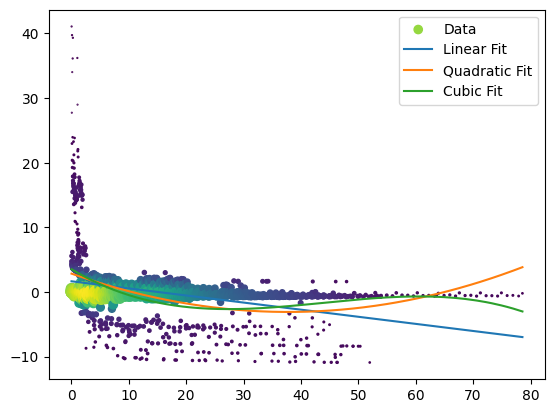

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde

# Create the data arrays
xdata=np.array(list(fixed_effect_model.ranef[0].index),dtype=float)
ydata=np.array(list(fixed_effect_model.ranef[0]["X.Intercept."]))

# Define the functions to fit the linear, quadratic, and cubic curves
def linear_fit(x, a, b):
    return a * x + b

def quadratic_fit(x, a, b, c):
    return a * x**2 + b * x + c

def cubic_fit(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit the linear, quadratic, and cubic curves to the data
linear_params = curve_fit(linear_fit, xdata, ydata)
quadratic_params = curve_fit(quadratic_fit, xdata, ydata)
cubic_params = curve_fit(cubic_fit, xdata, ydata)

# Create a plot of the data and the fitted curves
xy = np.vstack([xdata,ydata])
z = gaussian_kde(xy)(xy)
plt.scatter(xdata, ydata, c=z, s=z*10000, label='Data')
plt.plot(xdata, linear_fit(xdata, *linear_params[0]), label='Linear Fit')
plt.plot(xdata, quadratic_fit(xdata, *quadratic_params[0]), label='Quadratic Fit')
plt.plot(xdata, cubic_fit(xdata, *cubic_params[0]), label='Cubic Fit')
plt.legend()
plt.show()
